# Baseline solution for seismic facies identification challenge

### Architecture: U-Net
### Language: Tensorflow/keras

#### Considerations about the project:
 - Goals of project: Create a machine learning algorithm which, working from the raw 3D image, can reproduce an expert pixel-by-pixel identification.
 - Meaning of 3D Images: Seismic images of underground structures made during exploration of underground reservoirs (Sounds waves are sent to the ground and the echoes return to the surface. Then, the echoes are processed into three dimensional images highlighting interfaces between rocks with different properties)
 - Meaning of facies: The sum total characteristics of a rock that distinguishes it from adjacent rock
 - Challenge: Label each pixel (voxel) in a 3D seismic image of underground geological structures according to these 6 facies
 - Dataset: "Parihak",a 3D seismic image from a public-domain seismic survey

### Dependencies

In [1]:
import tensorflow as tf
import keras as K
from keras.layers import Input, BatchNormalization, Dropout, Dense, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
import time

from utils import input_crop, preprocess_data, convert_1_to_3_channel, jacard_coef, jacard_coef_loss
from model import unet

### Inputs

In [2]:
cropsize = (256,256)
stride = (256,256)
n_classes = 6

### Dataset

In [3]:
# load data
data_train = np.load('./dataset/data_train.npz')['data']
label_train = np.load('./dataset/labels_train.npz')['labels']
print(data_train.shape) # (Z,X,Y)
print(label_train.shape) # (Z,X,Y)

(1006, 782, 590)
(1006, 782, 590)


In [ ]:
# Plot 3d Visualizations
fig= mlab.figure(figure='seismic', bgcolor=(1, 1, 1), fgcolor=(0,0,0))
scalars = np.swapaxes(np.swapaxes(data_train,0,1),1,2)# specifying the data array
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig)   # crossline slice
mlab.volume_slice(scalars, slice_index=0,  plane_orientation='y_axes', figure=fig)   # inline slice
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig)   # depth slice
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=6) # Add axes labels 
mlab.show()

Text(0.5, 1.0, 'Ground Truth')

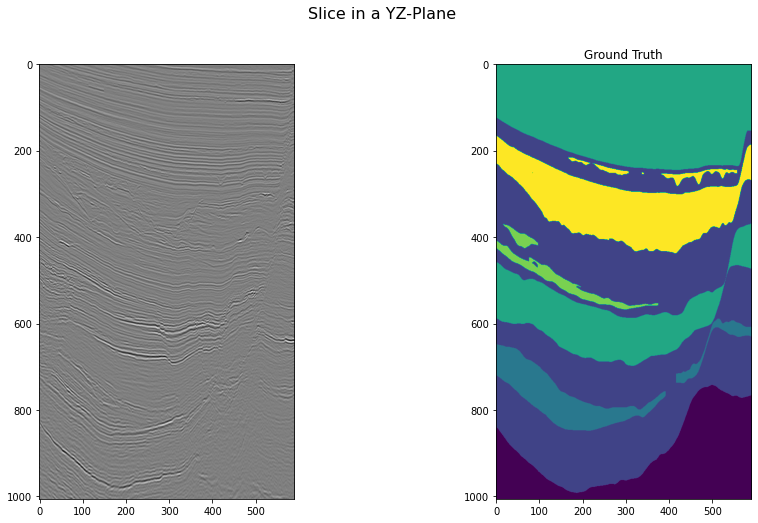

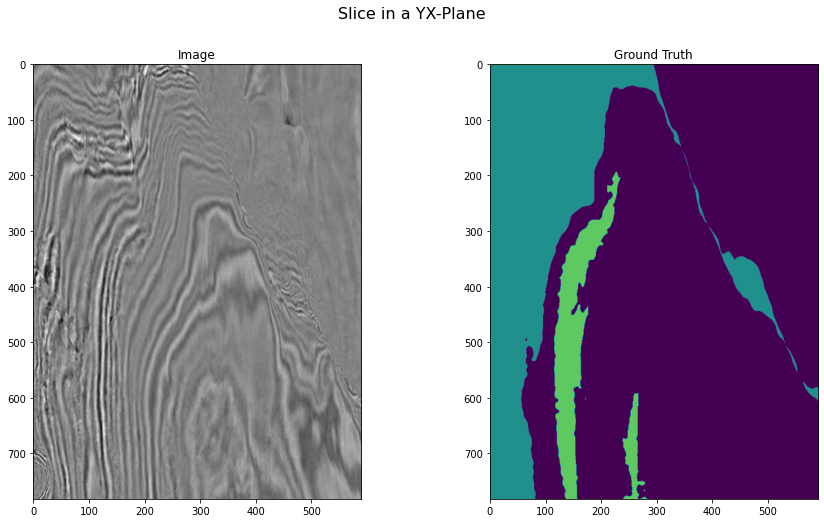

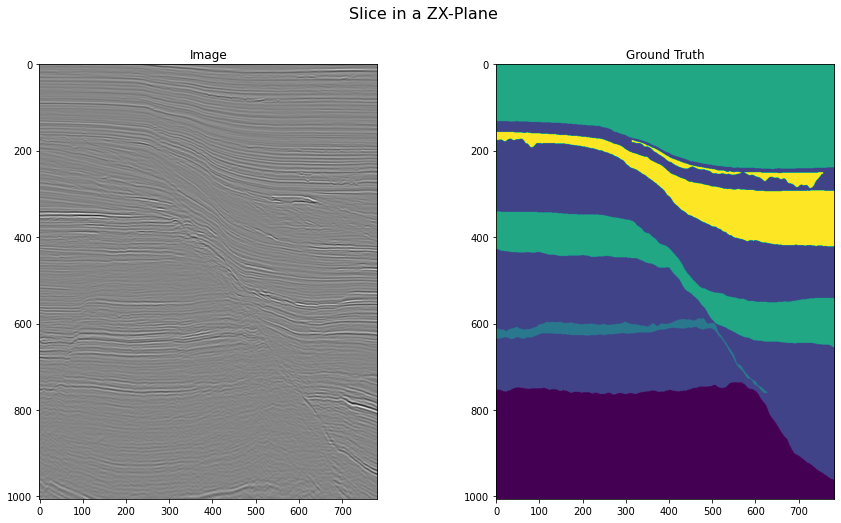

In [4]:
# Plot 2d Visualizations
fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YZ-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_train[:,500,:],cmap='gray')

ax1 = fig.add_subplot(122)
ax1.imshow(label_train[:,500,:])
ax1.set_title('Ground Truth')

fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YX-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_train[500,:,:],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_train[500,:,:])
ax1.set_title('Ground Truth')

fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a ZX-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_train[:,:,500],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_train[:,:,500])
ax1.set_title('Ground Truth')

## Data pre-processing

In [5]:
crops_img = np.array(preprocess_data(images=np.array(input_crop(data_train,label_train,cropsize, stride)[0])))

# convert label from (1 to 6) to (0 to 5) and expand dims
crops_label = np.array([*map((lambda x:
                              np.expand_dims(x-1,2)),input_crop(data_train,label_train,cropsize, stride)[1])])

In [6]:
print('Classes: ', np.unique(crops_label))

Classes:  [0 1 2 3 4 5]


In [7]:
del data_train, label_train

Text(0.5, 1.0, 'Ground Truth')

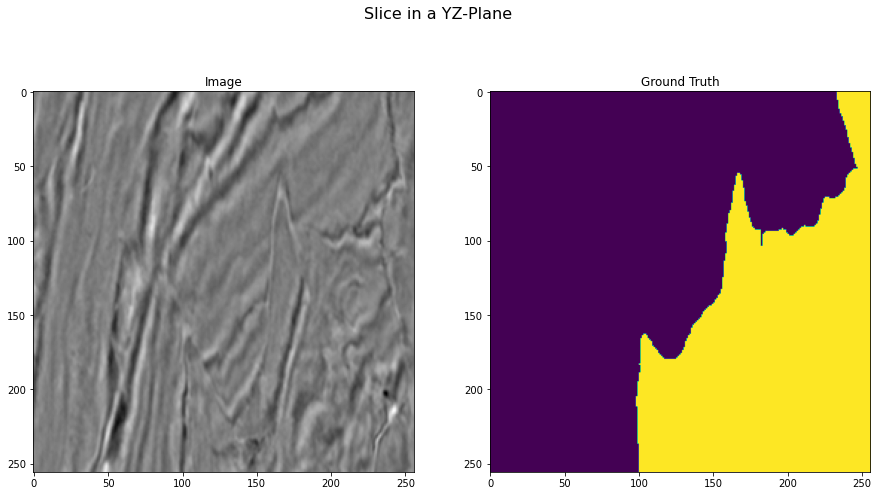

In [9]:
# plot one crop (image and label)
fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YZ-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(crops_img[2000,:,:,0],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(crops_label[2000,:,:,0])
ax1.set_title('Ground Truth')

In [12]:
# Random crop:
#idx = list(range(len(np.array(crop_scale))))
#idx = random.sample(idx,len(idx))
#crops_img = np.array(crop_scale)[idx].astype("float32")
#crops_label = np.array(label_crop)[idx].astype("float32") #.astype("int16")

In [10]:
# Split image in train and val
total = len(crops_img)
split = int(total*0.3)

val_image = crops_img[split:int(total*0.5)]
train_image = crops_img[:split]

val_label = to_categorical(crops_label[split:int(total*0.5)], num_classes=n_classes)
train_label = to_categorical(crops_label[:split], num_classes=n_classes)

In [11]:
del crops_img, crops_label

### Define Network architecture

In [12]:
# Define model
cropsize = [256,256]
lr = 0.0001
n_classes = 6
y_true = Input(shape=(cropsize[0],cropsize[1],1), name='y_true',dtype=tf.int8)

model = unet([cropsize[0],cropsize[1],3],n_classes)
model = Model(inputs=model.inputs, outputs=model.outputs)

# Optimizer
optim = tf.keras.optimizers.Adam(lr)

# Define loss 
#loss = generalized_dice_loss_w(y_true, model.get_layer("softmax").output)
#model.add_loss(loss)
#jaccard_loss = jc.dice_coef_9cat_loss(y_true, model.output)

#iou = jc.iou_score(y_true, model.output, n_classes, class_weights=1.)[0]
#print('iou',iou)

#dice_loss = sm.losses.DiceLoss(class_weights=weights) 
#model.add_loss(jaccard_loss)

#model.add_metric(iou, name=iou)

#metrics = [tf.keras.metrics.MeanIoU(num_classes=7)]

#model.compile(optimizer= optim, loss= None, metrics=metrics)
model.compile(optimizer=optim, loss= [jacard_coef_loss], metrics= [jacard_coef])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 25  0           ['conv2d_transpose_2[0][0]',     
                                6)                                'activation_3[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 12  512        ['conv2d_15[0][0]']              
 ormalization)                  8)                                                                
          

In [14]:
loss_history = []
acc_history = []
iou_history = []
num_epochs = 40
batch_size = 64
n_batches_train = len(train_image)//batch_size
n_batches_val = len(val_image)//batch_size


for epoch in range(num_epochs):
    print('Starting epoch {}-{}'.format(epoch+1, num_epochs))
    batch_start = 0 # Initial batch value of j epoch
    batch_end = batch_size  # Initial batch end of j epoch
    loss = 0
    iou_train = 0
    previous_loss = 99999 # initial previous_loss to put loss_val
    previous_loss_val = 99999
    
    start_time = time.time()
    for i in range(n_batches_train):
        history = model.train_on_batch(x=train_image[batch_start:batch_end],
                                        y=train_label[batch_start:batch_end]
                                       )
        #print(history)
        batch_start+=batch_size
        batch_end+=batch_size
        loss+=history[0]
        iou_train += history[1]
    end_time = time.time()
    print("epoch time: ",end_time - start_time)
    
    loss = loss/n_batches_train # Average loss function of all batches in j epoch (train)
    iou_train = iou_train/n_batches_train # Average IOU of all batches in j epoch (train)
    
    #Val
    
    batch_start_val = 0
    batch_end_val = batch_size
    loss_val = 0
    iou_val = 0
    
    for i in range(n_batches_val):  
        history_val = model.test_on_batch(x=val_image[batch_start_val:batch_end_val],
                                           y=val_label[batch_start_val:batch_end_val]
                                         )
        batch_start_val+=batch_size
        batch_end_val+=batch_size
        loss_val+=history_val[0]
        iou_val += history_val[1]
        
    loss_val = loss_val/n_batches_val
    iou_val = iou_val/n_batches_val
    
    if loss_val < previous_loss_val:
        model.save_weights('diceloss_unet_' + str(cropsize)+ "_" +  "_nclass_"
                           + str(n_classes) + '_seg_' + 'weights.h5')
        previous_loss_val = loss_val
        
    if loss < previous_loss:
        model.save_weights('diceloss_unet_' + str(cropsize) + "_" + "_nclass_" 
                           + str(n_classes) + '_seg_' + 'weights_best_Train.h5')
        loss_ant = loss


    print("loss train: ",loss)
    print("iou train: ",iou_train)
    print("loss val: ",loss_val)

Starting epoch 1-40
epoch time:  1763.7453181743622
loss train:  0.8898812021527972
iou train:  0.11011879545237337
loss val:  0.9619755413797166
Starting epoch 2-40
epoch time:  1797.417452096939
loss train:  0.7952734274523598
iou train:  0.20472657294677837
loss val:  0.9552450378735861
Starting epoch 3-40
epoch time:  1749.5820307731628
loss train:  0.735299751162529
iou train:  0.26470025229666916
loss val:  0.9283775521649255
Starting epoch 4-40
epoch time:  1723.7654972076416
loss train:  0.705921185868127
iou train:  0.2940788149301495
loss val:  0.9074303574032254
Starting epoch 5-40
epoch time:  1713.6571743488312
loss train:  0.6806074615035739
iou train:  0.31939253743205753
loss val:  0.913700520992279
Starting epoch 6-40
epoch time:  1711.6934025287628
loss train:  0.6594326368400029
iou train:  0.3405673638252275
loss val:  0.9317065874735514
Starting epoch 7-40
epoch time:  1730.6473968029022
loss train:  0.6492109362568174
iou train:  0.3507890652066895
loss val:  0.92